In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
pd.options.mode.copy_on_write = True

In [2]:
# importiamo i csv con tutti i dati
conStand = pd.read_csv('../dataSets/f1-od/constructor_standings.csv')
driveStand = pd.read_csv('../dataSets/f1-od/driver_standings.csv')
pit = pd.read_csv('../dataSets/f1-od/pitstops.csv')

Numero di team in Formula 1 negli anni

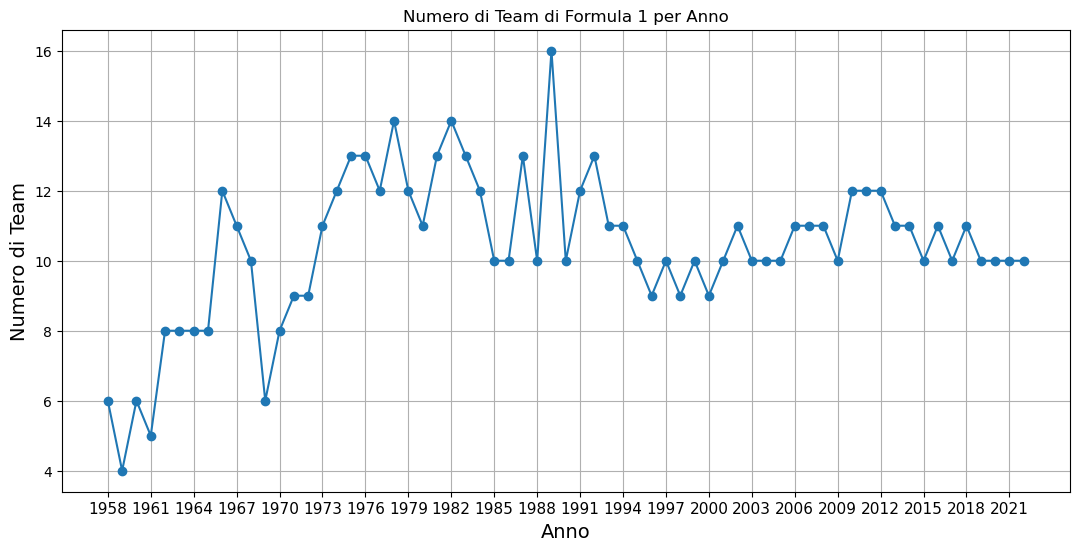

In [3]:
# Conta il numero di team per ogni anno
teams_count_per_year = conStand.groupby('Year')['Team'].nunique().reset_index()

# Rinomina le colonne per chiarezza
teams_count_per_year.columns = ['Year', 'Number of Teams']

# Crea il grafico a linee
plt.figure(figsize=(13, 6))
plt.plot(teams_count_per_year['Year'], teams_count_per_year['Number of Teams'], marker='o', linestyle='-')
plt.title('Numero di Team di Formula 1 per Anno')
plt.xlabel('Anno', fontsize=14)
plt.xticks(teams_count_per_year['Year'][::3], fontsize=11)
plt.ylabel('Numero di Team',fontsize=14)
plt.grid(True)
plt.show()

Top 50 permanenza in f1 dei team (dal 1958)

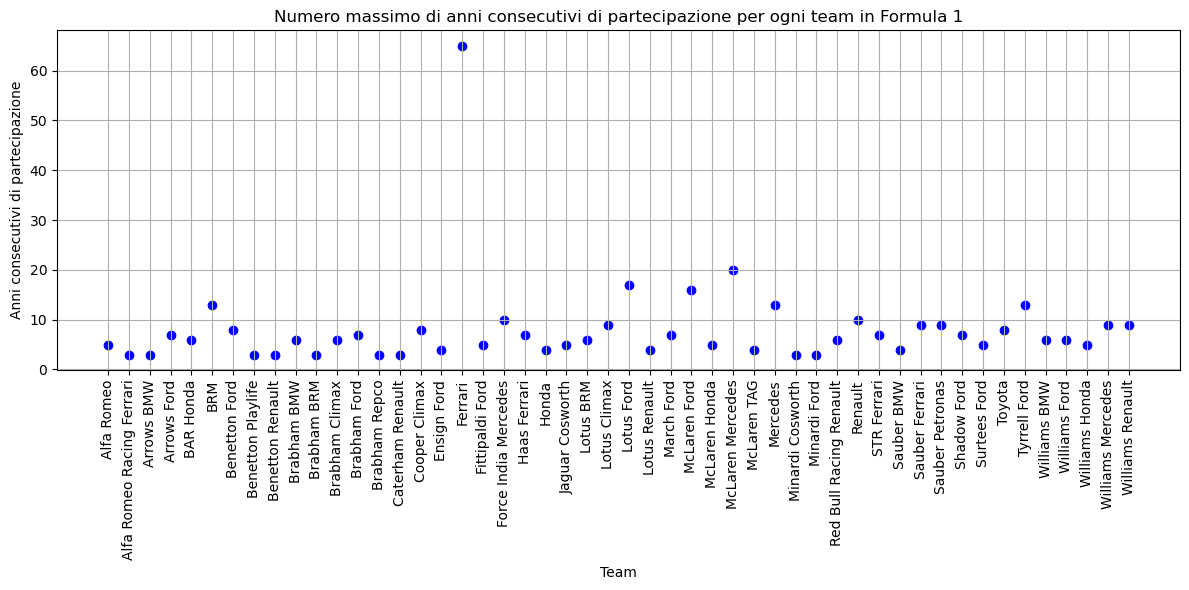

In [4]:
# Passo 2: Ordinare i dati per Team e Year
conStand = conStand.sort_values(by=['Team', 'Year'])

# Passo 3: Calcolare le sequenze consecutive di anni per ogni team
def calculate_consecutive_years(team_conStand):
    team_conStand['Year_Diff'] = team_conStand['Year'].diff().fillna(1)
    team_conStand['Consecutive_Block'] = (team_conStand['Year_Diff'] > 1).cumsum()
    consecutive_counts = team_conStand.groupby('Consecutive_Block').size()
    return consecutive_counts.max()    

# Passo 4: Applicare la funzione a ciascun team
teams_max_consecutive = conStand.groupby('Team').apply(calculate_consecutive_years, include_groups=False).reset_index()
teams_max_consecutive.columns = ['Team', 'Max_Consecutive_Years']
team_piu_anni = teams_max_consecutive.sort_values(by = 'Max_Consecutive_Years', ascending = False).head(50)
teams_max_consecutive = teams_max_consecutive[teams_max_consecutive['Team'].isin(team_piu_anni['Team'])]



# Passo 5: Creare il grafico a dispersione
plt.figure(figsize=(12, 6))
plt.scatter(teams_max_consecutive['Team'], teams_max_consecutive['Max_Consecutive_Years'], color='blue')
plt.xticks(rotation=90)
plt.title('Numero massimo di anni consecutivi di partecipazione per ogni team in Formula 1')
plt.xlabel('Team')
plt.ylabel('Anni consecutivi di partecipazione')
plt.grid(True)
plt.tight_layout()
plt.show()

Top 10 costruttori

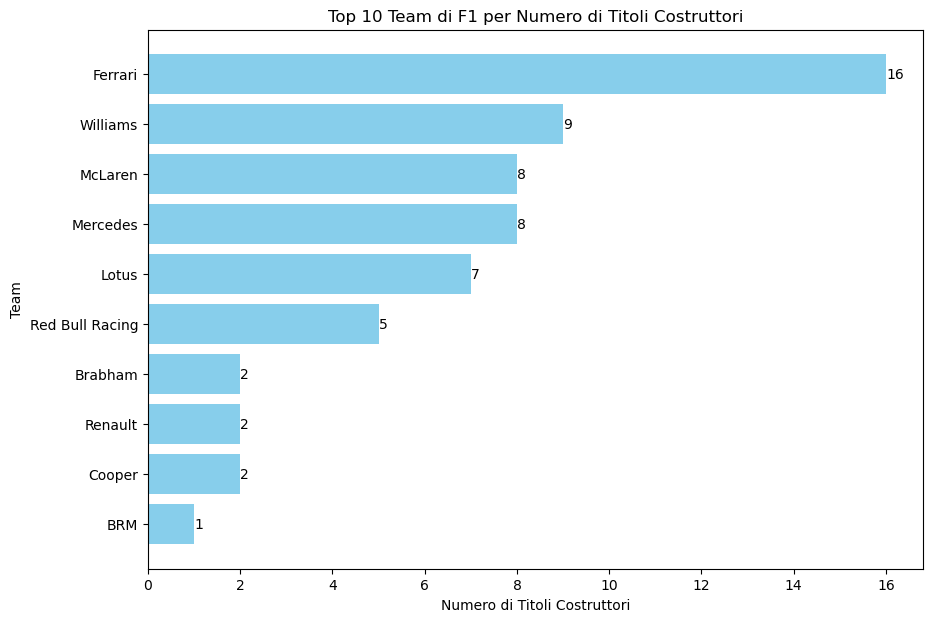

In [5]:
# Converti la colonna 'Pos' in numerico per raceDet, sostituendo le stringhe con 100
conStand['Pos'] = pd.to_numeric(conStand['Pos'], errors='coerce').fillna(100).astype(int)

# Filtra solo i team che hanno vinto (Pos = 1)
winners = conStand[conStand['Pos'] == 1]

# Funzione per normalizzare i nomi dei team (rimuovere l'ultima parola)
def normalize_team_name(team_name):
    return ' '.join(team_name.split(' ')[:-1]) if len(team_name.split(' ')) > 1 else team_name

# Applica la normalizzazione ai nomi dei team
winners['Normalized Team'] = winners['Team'].apply(normalize_team_name)

# Conta il numero di titoli per ogni team normalizzato
team_titles = winners.groupby('Normalized Team').size().sort_values(ascending=False)

# Estrai i 10 team con più titoli
top_10_teams = team_titles.head(10)
teams = top_10_teams.index.tolist()  # Converti l'indice in una lista di stringhe
titles = top_10_teams.values

# Crea il grafico a barre orizzontali
plt.figure(figsize=(10, 7))
plt.barh(teams, titles, color='skyblue')
plt.xlabel('Numero di Titoli Costruttori')
plt.ylabel('Team')
plt.title('Top 10 Team di F1 per Numero di Titoli Costruttori')
plt.gca().invert_yaxis()  # Inverti l'asse Y per avere il primo in alto

for index, value in enumerate(titles):
    plt.text(value, index, str(value), va='center', ha='left')  # Posiziona il testo all'inizio della barra

plt.show()

top 10 maggior numero di costruttori di fila

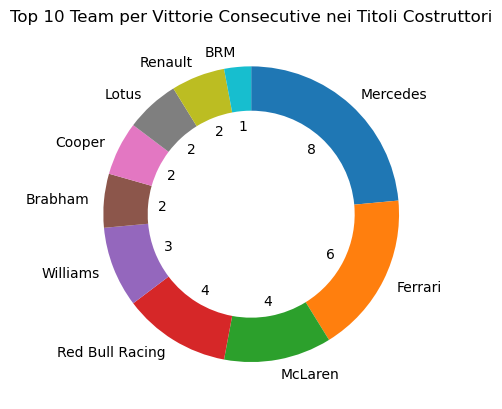

In [6]:
# Converti la colonna 'Pos' in numerico per raceDet, sostituendo le stringhe con 100
conStand['Pos'] = pd.to_numeric(conStand['Pos'], errors='coerce').fillna(100).astype(int)

# Step 3: Pre-processare i dati per normalizzare i nomi dei team
# Rimuovere l'ultima parola nei nomi dei team che hanno più di una parola
conStand['Normalized Team'] = conStand['Team'].apply(lambda x: ' '.join(x.split()[:-1]) if len(x.split()) > 1 else x)

# Filtrare i dati per considerare solo i team che hanno vinto (Pos == 1)
winners_conStand = conStand[conStand['Pos'] == 1].sort_values(by='Year')


# Step 4: Calcolare le sequenze di vittorie consecutive per ogni team
consecutive_wins = {}

# Calcoliamo il numero massimo di vittorie consecutive per ogni team
for team, group in winners_conStand.groupby('Normalized Team'):
    group = group.sort_values('Year')
    max_consecutive = 0
    current_consecutive = 0
    last_year = None

    for _, row in group.iterrows():
        if last_year is None or row['Year'] == last_year + 1:
            current_consecutive += 1
        else:
            current_consecutive = 1

        last_year = row['Year']
        max_consecutive = max(max_consecutive, current_consecutive)

    consecutive_wins[team] = max_consecutive

# Step 5: Identificare i top 10 team con le sequenze di vittorie consecutive più lunghe
top_10_teams = sorted(consecutive_wins.items(), key=lambda x: x[1], reverse=True)[:10]

# Separare i nomi dei team e i loro rispettivi conteggi di vittorie consecutive
teams, wins = zip(*top_10_teams)

def func(pct, allvals):
    absolute = int(math.ceil(pct/100.*sum(allvals)))
    return "{:d}".format(absolute)

# Step 6: Creare un grafico ad anello per rappresentare questi dati
fig, ax = plt.subplots()

# Creare un grafico a torta con uno "spazio" nel centro per farlo sembrare un anello
ax.pie(
    wins, 
    labels=teams, 
    startangle=90, 
    counterclock=False, 
    wedgeprops=dict(width=0.3),
    autopct=lambda pct: func(pct, wins) # Aggiunge i valori numerici direttamente sulle sezioni
)

# Impostazioni aggiuntive per rendere il grafico più chiaro
ax.set(aspect="equal", title='Top 10 Team per Vittorie Consecutive nei Titoli Costruttori')

plt.show()

costruttori con più mondiali piloti

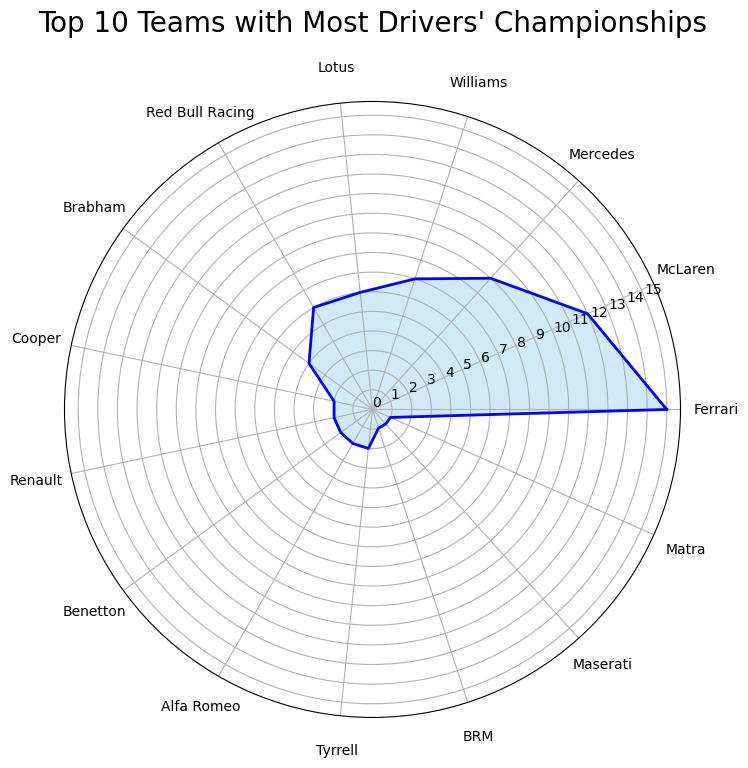

In [7]:
# Raggruppa i dati per anno e trova il pilota con il maggior numero di punti
driveStand['Year'] = driveStand['Year'].astype(int)  # Assicurati che la colonna 'Year' sia di tipo int
champions = driveStand.loc[driveStand.groupby('Year')['PTS'].idxmax()]

# Step 3: Pre-processare i dati per normalizzare i nomi dei team
# Rimuovere l'ultima parola nei nomi dei team che hanno più di una parola
champions['Team'] = champions['Car'].apply(lambda x: ' '.join(x.split()[:-1]) if len(x.split()) > 1 else x)

# Conta il numero di titoli per ciascun team
team_titles = champions['Team'].value_counts().head(15)

# Imposta i dati per il grafico polare
teams = team_titles.index
titles = team_titles.values

# Converti i dati in coordinate per il grafico polare
angles = np.linspace(0, 2 * np.pi, len(teams), endpoint=False).tolist()
angles += angles[:1]
titles = np.append(titles, titles[0])

# Crea il grafico polare
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

ax.fill(angles, titles, color='skyblue', alpha=0.4)
ax.plot(angles, titles, color='blue', linewidth=2)

# Aggiungi le etichette dei team
ax.set_xticks(angles[:-1])
ax.set_xticklabels(teams)
ax.tick_params(axis='x', which='major', pad=15)

# Aggiungi le etichette dei valori radiali sugli assi
ax.set_yticks(range(0, max(titles) + 1))
ax.set_yticklabels(map(str, range(0, max(titles) + 1)))

# Imposta il titolo del grafico
plt.title("Top 10 Teams with Most Drivers' Championships", size=20, y=1.1)

plt.show()

Velocità pit stop dal 1994 al 2009 (rifornimenti concessi)

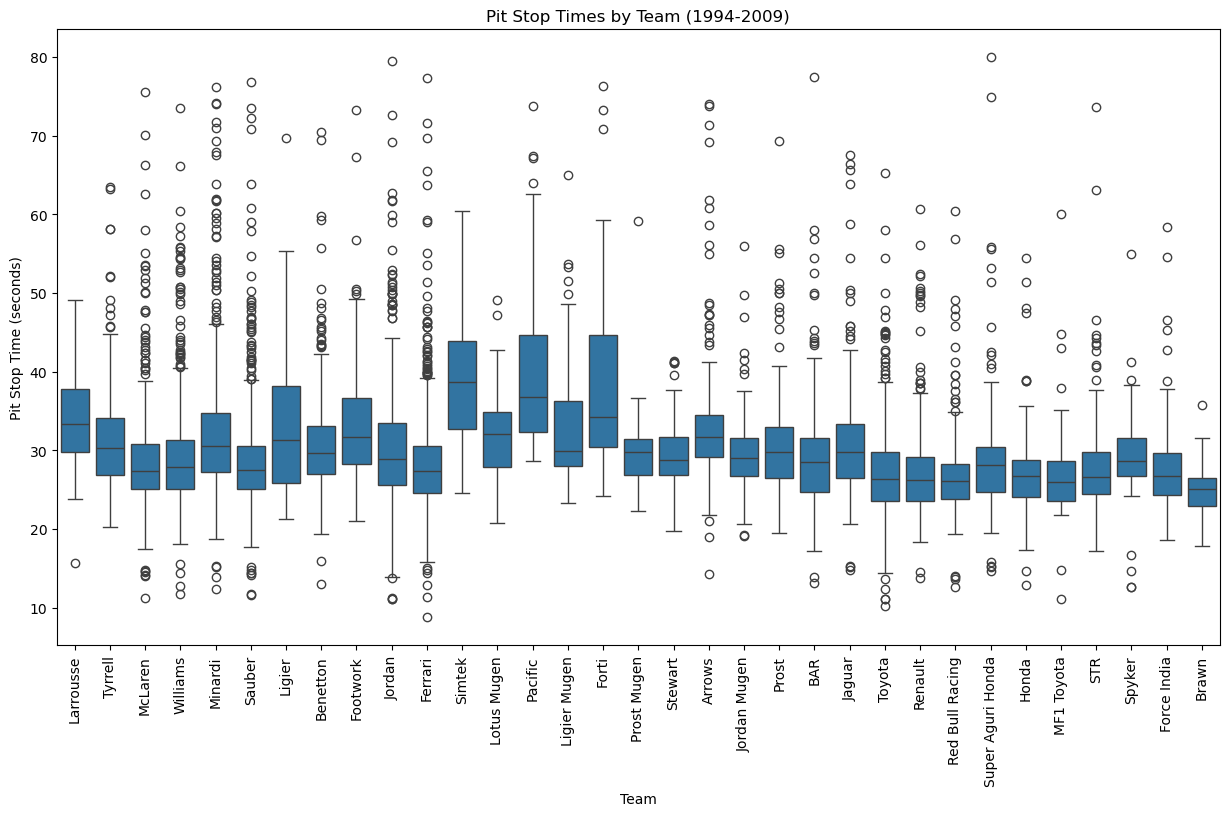

In [8]:
pit_local = pit
# 2. Filtrare i dati per includere solo gli anni dal 1994 al 2009
pit_local = pit_local[(pit_local['Year'] >= 1994) & (pit_local['Year'] <= 2009)]

pit_local = pit_local.dropna(subset=['Car','Time'])

# 3. Normalizzare i nomi dei team
pit_local['Team'] = pit_local['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# 4. Convertire i tempi dei pit_local stop in formato numerico (secondi)
# Assumendo che il formato del tempo sia 'm:ss.sss'
def convert_time_to_seconds(time_str):
    # t1 contiene i secondi se non ci sono minuti; altrimenti contiene i minuti in time_str
    # t2 viene riempito solo se ci sono minuti in time_str e in quel caso contiene i secondi
    t1, *t2 = time_str.split(':')
    return float(t1) if t2 == [] else int(t1) * 60 + float(t2[0])

pit_local['PitStopTimeSeconds'] = pit_local['Time'].apply(convert_time_to_seconds)
# rimozione dei pit sopra gli 80 secondi (sono eventi come bandiere rosse o auto ritirate dopo del tempo in pitlane)
pit_local = pit_local[pit_local['PitStopTimeSeconds'] < 80]

# 5. Creare il grafico box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='Team', y='PitStopTimeSeconds', data=pit_local)
plt.xticks(rotation=90)
plt.title('Pit Stop Times by Team (1994-2009)')
plt.xlabel('Team')
plt.ylabel('Pit Stop Time (seconds)')
plt.show()

Velocità pit stop dal 2010 (rifornimenti banditi)

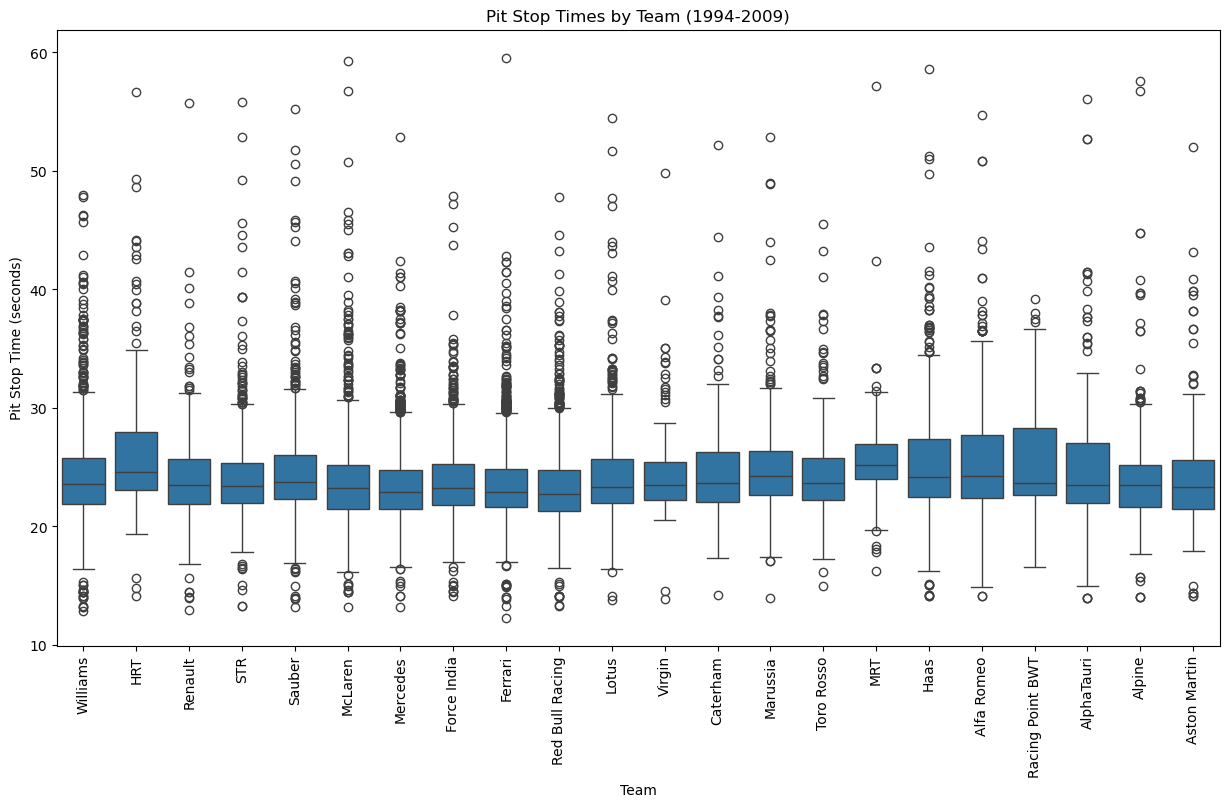

In [10]:
pit_local = pit
# 2. Filtrare i dati per includere solo gli anni dal 1994 al 2009
pit_local = pit_local[pit_local['Year'] >= 2010]

pit_local = pit_local.dropna(subset=['Car','Time'])

# 3. Normalizzare i nomi dei team
pit_local['Team'] = pit_local['Car'].apply(lambda x: ' '.join(str(x).split()[:-1]) if len(str(x).split()) > 1 else str(x))

# 4. Convertire i tempi dei pit_local stop in formato numerico (secondi)
# Assumendo che il formato del tempo sia 'm:ss.sss'
def convert_time_to_seconds(time_str):
    # t1 contiene i secondi se non ci sono minuti; altrimenti contiene i minuti in time_str
    # t2 viene riempito solo se ci sono minuti in time_str e in quel caso contiene i secondi
    t1, *t2 = time_str.split(':')
    return float(t1) if t2 == [] else int(t1) * 60 + float(t2[0])

pit_local['PitStopTimeSeconds'] = pit_local['Time'].apply(convert_time_to_seconds)
# rimozione dei pit sopra gli 60 secondi (sono eventi come bandiere rosse o auto ritirate dopo del tempo in pitlane)
pit_local = pit_local[pit_local['PitStopTimeSeconds'] < 60]

# 5. Creare il grafico box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='Team', y='PitStopTimeSeconds', data=pit_local)
plt.xticks(rotation=90)
plt.title('Pit Stop Times by Team (1994-2009)')
plt.xlabel('Team')
plt.ylabel('Pit Stop Time (seconds)')
plt.show()